### Carregando os arquivo para geração do modelo

In [1]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Carrega no Dataframe somente os dados que serão usados para treinar o modelo
lista_indicadores = ['vl_licitacao','indicador1','indicador2','indicador3','indicador4']
df_csv = pd.read_csv('indicadores6.csv')[['id','vl_licitacao',
                                          'indicador1','indicador2','indicador3','indicador4']]

In [3]:
# Visualizando algumas linhas iniciais dos dados carregados
df_csv[:5]

,id,vl_licitacao,indicador1,indicador2,indicador3,indicador4
0,3,7000.0,0.917143,1,0.67,0
1,4,300000.0,1.000012,1,0.00,0
2,5,44000.0,1.000000,0,0.00,0
3,6,18000.0,1.000000,0,0.00,0
4,7,46920.0,0.408696,0,0.00,0


In [4]:
# Buscando dados para cluster
df=df_csv[lista_indicadores ]
df.shape

(10273, 5)

In [5]:
#### Desativando o scaling dos dados
from sklearn import preprocessing

df=df_csv[lista_indicadores]
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(df.values.astype(float))
df_normalized = pd.DataFrame(scaled_array)
df_normalized[:5]

,0,1,2,3,4
0,0.000007,0.000920,1.0,0.67,0.0
1,0.000300,0.001003,1.0,0.00,0.0
2,0.000044,0.001002,0.0,0.00,0.0
3,0.000018,0.001002,0.0,0.00,0.0
4,0.000047,0.000411,0.0,0.00,0.0


In [22]:
# Cronometrando tempo para treinamento do modelo
import time

data = df_normalized.to_numpy()
start_time = time.time()
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=160, 
    prediction_data=True,
    cluster_selection_method='eom').fit(data)
time.time() - start_time

1.7971067428588867

In [23]:
max(clusterer.labels_)

7

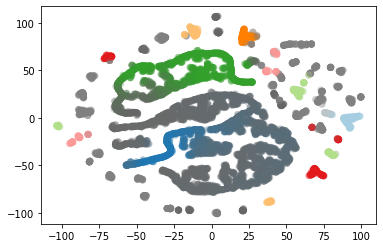

In [24]:
# Visualizando os dados após clusterização
from sklearn.manifold import TSNE
projection = TSNE().fit_transform(data)

color_palette = sns.color_palette('Paired', 16)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [25]:
df_clusterized = pd.DataFrame({'Id': df_csv['id'] ,'Grupo': clusterer.labels_, 'Prob': clusterer.probabilities_})
df_clusterized.to_csv("clusterized.csv")
df_clusterized

,Id,Grupo,Prob
0,3,4,1.000000
1,4,3,1.000000
2,5,1,0.386890
3,6,1,0.940000
4,7,1,0.046851
...,...,...,...
10268,16996,2,1.000000
10269,16997,1,0.490637
10270,16998,1,0.082379
10271,16999,-1,0.000000


In [26]:
pd.concat([df,df_clusterized],axis=1).to_csv("analise.csv")

### Salvando dados do modelo em arquivo
import pickle

with open('hdbscan-model.pkl', 'wb') as output:
    pickle.dump(clusterer, output, pickle.HIGHEST_PROTOCOL)

with open('hdbscan-projection_params.pkl', 'wb') as output:
    pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

with open('hdbscan-projection.pkl', 'wb') as output:
    pickle.dump(projection, output, pickle.HIGHEST_PROTOCOL)

## Código para forçar classificação dos sem grupo

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

### Outliar Detection

data = np.load('clusterable_data.npy')
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

import pandas as pd
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)